<a href="https://colab.research.google.com/github/pkseniya/DLS/blob/master/Home%20work%20Style%20Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

### Будем реализовывать Neural Style Transfer.

In [0]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
! wget https://www.dropbox.com/s/0t1armlrntdmhg9/nst.zip

--2020-06-14 11:24:54--  https://www.dropbox.com/s/0t1armlrntdmhg9/nst.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0t1armlrntdmhg9/nst.zip [following]
--2020-06-14 11:24:54--  https://www.dropbox.com/s/raw/0t1armlrntdmhg9/nst.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb8fd7aac450a38066c2077524.dl.dropboxusercontent.com/cd/0/inline/A5rHImJoBuytXZ80YSYc12KVZonZxoEQS7agjV2A582a53rnifpdHnG2rOrPfIUrPFeGAbX-cdHKKPqIFGVFVaz0Agchpo44oYjJ_M2XTOBHudBTlVP9IfOhlhhL2R4Olug/file# [following]
--2020-06-14 11:24:54--  https://uccb8fd7aac450a38066c2077524.dl.dropboxusercontent.com/cd/0/inline/A5rHImJoBuytXZ80YSYc12KVZonZxoEQS7agjV2A582a53rnifpdHnG2rOrPfIUrPFeGAbX-cdHKKPqIFGVFVaz0Agchpo44oYjJ_M2XTOBHudBTlVP9IfOhlhhL2R

In [0]:
!unzip -q /content/nst.zip -d nst

In [4]:
!ls nst/nst

baikal.jpg  frogs.jpg	   languedoc.jpg  munch.jpg	plane.jpg
degas.jpg   graphics.jpg   monet1.jpg	  picasso2.jpg	rubens.jpg
dog.jpg     kandinsky.jpg  monet2.jpg	  picasso.jpg


In [0]:
imsize = 768

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

baikal = image_loader("nst/nst/baikal.jpg")
frogs = image_loader("nst/nst/frogs.jpg")
languedoc = image_loader("nst/nst/languedoc.jpg")
munch = image_loader("nst/nst/munch.jpg")
plane = image_loader("nst/nst/plane.jpg")
degas = image_loader("nst/nst/degas.jpg")
graphics = image_loader("nst/nst/graphics.jpg")
monet1 = image_loader("nst/nst/monet1.jpg") 
monet2 = image_loader("nst/nst/monet2.jpg") 
picasso = image_loader("nst/nst/picasso.jpg") 
picasso2 = image_loader("nst/nst/picasso2.jpg") 
rubens = image_loader("nst/nst/rubens.jpg") 
dog = image_loader("nst/nst/dog.jpg")
kandinsky = image_loader("nst/nst/kandinsky.jpg") 

In [7]:
device

device(type='cuda')

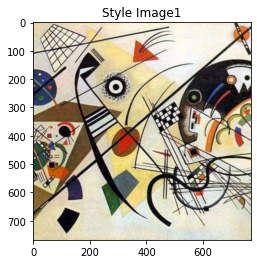

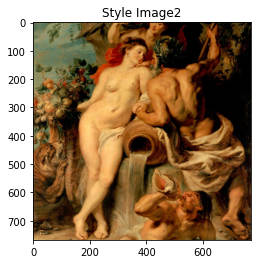

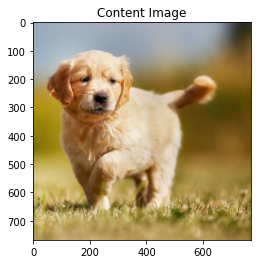

In [25]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка
plt.figure()
imshow(kandinsky, title='Style Image1')
plt.figure()
imshow(rubens, title='Style Image2')
plt.figure()
imshow(dog, title='Content Image')


In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach() #это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target) #to initialize with something

        def forward(self, input_img):
            self.loss = F.mse_loss(input_img, self.target)
            return input_img

In [0]:
def gram_matrix(input_img):
        batch_size, f_map_num, h, w = input_img.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input_img.view(batch_size * f_map_num, h * w)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Для переноса двух изображений будем учитывать потери каждого стиля с определенной долей, которую можно вводить.

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2, percent):
            super(StyleLoss, self).__init__()
            self.target1 = gram_matrix(target_feature1).detach()
            self.target2 = gram_matrix(target_feature2).detach()
            self.loss = F.mse_loss(self.target1, self.target1)# to initialize with something
            self.percent = percent

        def forward(self, input_img):
            G = gram_matrix(input_img)
            self.loss = (self.percent * F.mse_loss(G, self.target1) + (100-self.percent) * F.mse_loss(G, self.target2))/100
            return input_img

Для переноса двух картинок модифицируем функцию вычисления матриц Грама: будем измерять схожесть стиля не на всей картинке, а только на ее половинах: левой, правой, верхней, нижней.

In [0]:
def half_gram_matrix(input_img, side):
        batch_size , f_map_num, h, w = input_img.size()  # batch size(=1)
        
        # (h,w)=dimensions of a feature map (N=h*w)

        if side == 'top':
            features = input_img.view(batch_size * f_map_num, h * w)
            features = features[:, :int(h/2)*w] 
        elif side == 'bottom':
            features = input_img.view(batch_size * f_map_num, h * w)
            features = features[:, int(h/2)*w:] 
        elif side == 'left':
            input_img = torch.transpose(torch.transpose(input_img, 2,3)[:,:,:int(h/2),:],2,3)
            features = input_img.reshape(batch_size * f_map_num, int(h * w/2))
            
        else:
            input_img = torch.transpose(torch.transpose(input_img, 2,3)[:,:,int(h/2):,:],2,3)
            features = input_img.reshape(batch_size * f_map_num, int(h * w/2))

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [0]:
class HalfStyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2, mode):
            super(HalfStyleLoss, self).__init__()
            if mode == 'tb':
                self.target1 = half_gram_matrix(target_feature1, 'top').detach()
                self.target2 = half_gram_matrix(target_feature2, 'bottom').detach()
            elif mode == 'bt':
                self.target1 = half_gram_matrix(target_feature1, 'bottom').detach()
                self.target2 = half_gram_matrix(target_feature2, 'top').detach()
            elif mode == 'lr':
                self.target1 = half_gram_matrix(target_feature1, 'left').detach()
                self.target2 = half_gram_matrix(target_feature2, 'right').detach()
            else:            
                self.target1 = half_gram_matrix(target_feature1, 'right').detach()
                self.target2 = half_gram_matrix(target_feature2, 'left').detach()
            self.loss = F.mse_loss(self.target1, self.target1)# to initialize with something
            self.mode = mode

        def forward(self, input_img):
            if self.mode == 'tb':
                G1 = half_gram_matrix(input_img, 'top')
                G2 = half_gram_matrix(input_img, 'bottom')
            elif self.mode == 'bt':
                G1 = half_gram_matrix(input_img, 'bottom')
                G2 = half_gram_matrix(input_img, 'top')
            elif self.mode == 'lr':
                G1 = half_gram_matrix(input_img, 'left')
                G2 = half_gram_matrix(input_img, 'right')
            else:
                G1 = half_gram_matrix(input_img, 'right')
                G2 = half_gram_matrix(input_img, 'left')
            self.loss = (F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2))/2
            return input_img

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [16]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, 
                                   style_img1, style_img2, content_img, mode, percent,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style_img1).detach()
                target_feature2 = model(style_img2).detach()
                if mode == 'both':
                    style_loss = StyleLoss(target_feature1, target_feature2, percent)
                else:
                    style_loss = HalfStyleLoss(target_feature1, target_feature2, mode)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if mode == 'both':
                if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                    break
            else:
                 if isinstance(model[i], ContentLoss) or isinstance(model[i], HalfStyleLoss):
                    break             

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img1, style_img2, input_img,
                        mode = 'both', percent = 50, num_steps=500,
                        style_weight=100000, content_weight=1):
      
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img1, style_img2, content_img, mode, percent)
        optimizer = get_input_optimizer(input_img)
        sheduler = sched.StepLR(optimizer=optimizer, step_size =70, gamma =0.8)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)
                
                optimizer.zero_grad()
                
                model(input_img)

                style_score = 0
                content_score = 0
                
                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score

                loss.backward()
                
                run[0] += 1

                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()
                    plt.figure()
                    imshow(input_img, title='Image')
                    plt.ioff()
                    plt.show()
                  
                return style_score + content_score
            
            optimizer.step(closure)
            
            sheduler.step()

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


run [50]:
Style Loss : 163.707489 Content Loss: 20.095345



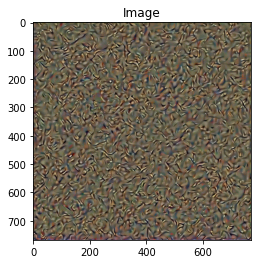

run [100]:
Style Loss : 151.334579 Content Loss: 16.352602



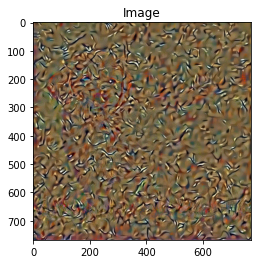

run [150]:
Style Loss : 147.109222 Content Loss: 14.102210



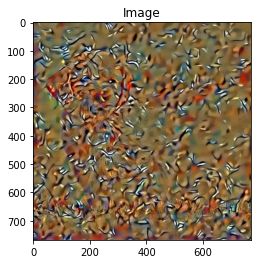

run [200]:
Style Loss : 144.699005 Content Loss: 12.696282



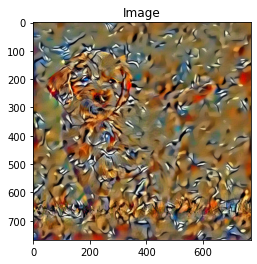

run [250]:
Style Loss : 145.186081 Content Loss: 12.248792



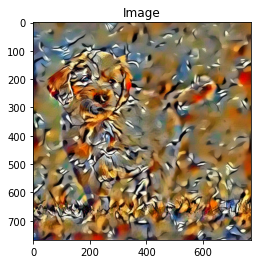

run [300]:
Style Loss : 141.858444 Content Loss: 11.334086



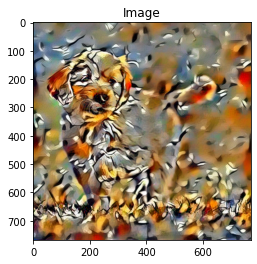

run [350]:
Style Loss : 146.542374 Content Loss: 11.239170



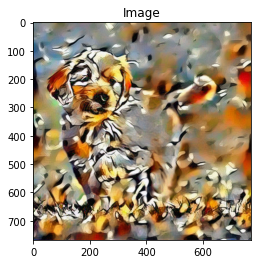

run [400]:
Style Loss : 139.527374 Content Loss: 10.906089



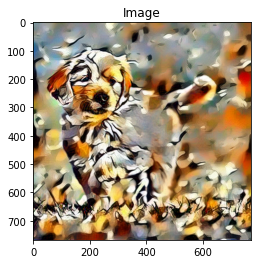

run [450]:
Style Loss : 142.068710 Content Loss: 12.859835



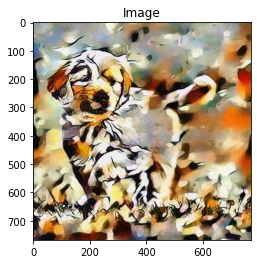

run [500]:
Style Loss : 138.905701 Content Loss: 10.316729



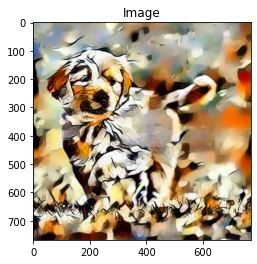

In [24]:
torch.manual_seed(42)
input_img = torch.randn(dog.data.size(), device=device)
'''
mode может быть:
    'both' - сразу два стиля - по дефолту
    'tb'/'bt' - первая картинка переносится на верхнюю часть, вторая - на нижнюю / наоборот
    'lr'/'rl' - первая картинка переносится на левую часть, вторая - на правую / наоборот
'''
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            dog, kandinsky, rubens, input_img, mode = 'both', percent = 60) 

Два стиля сразу:

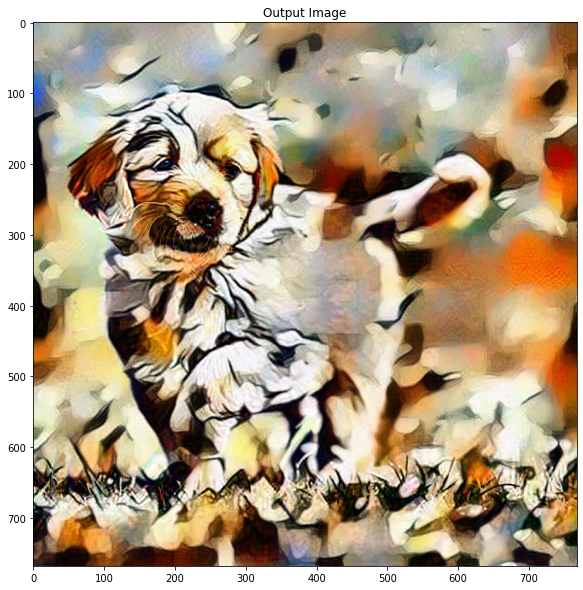

In [36]:
plt.figure(figsize=(10,10))
imshow(output, title='Output Image')
plt.ioff()
plt.show()

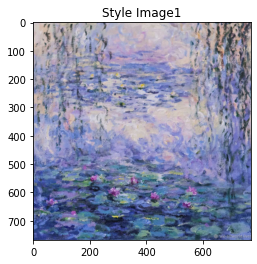

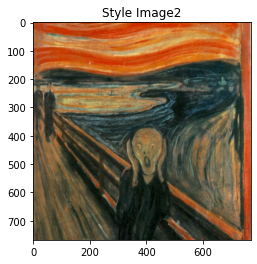

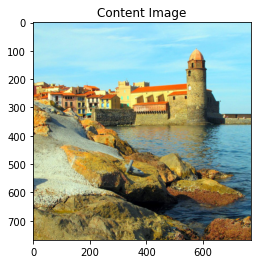

In [29]:
plt.figure()
imshow(monet1, title='Style Image1')
plt.figure()
imshow(munch, title='Style Image2')
plt.figure()
imshow(languedoc, title='Content Image')

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


run [50]:
Style Loss : 3.795306 Content Loss: 7.436328



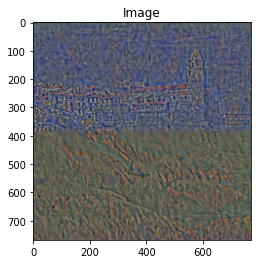

run [100]:
Style Loss : 2.111050 Content Loss: 5.041916



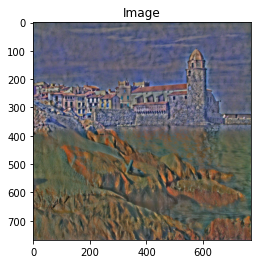

run [150]:
Style Loss : 1.505157 Content Loss: 4.544867



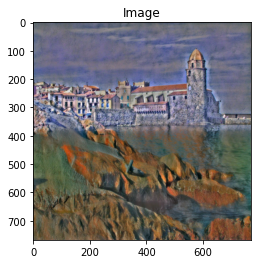

run [200]:
Style Loss : 1.202164 Content Loss: 4.363463



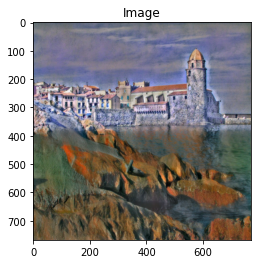

run [250]:
Style Loss : 1.039350 Content Loss: 4.280936



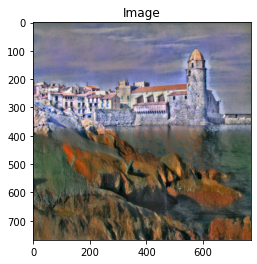

run [300]:
Style Loss : 0.961432 Content Loss: 4.236248



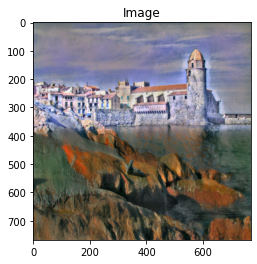

run [350]:
Style Loss : 0.920217 Content Loss: 4.197068



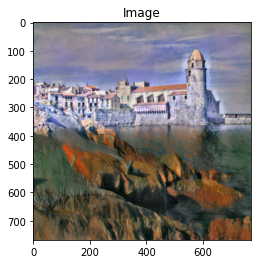

run [400]:
Style Loss : 0.890763 Content Loss: 4.170214



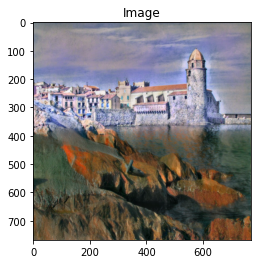

run [450]:
Style Loss : 0.875066 Content Loss: 4.138521



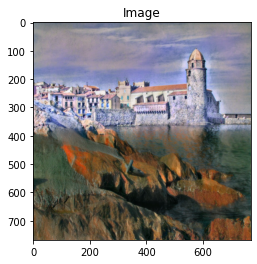

run [500]:
Style Loss : 0.861612 Content Loss: 4.114117



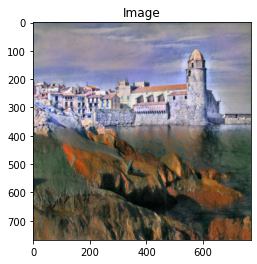

In [28]:
torch.manual_seed(42)
input_img = torch.randn(languedoc.data.size(), device=device)
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            languedoc, monet1, munch, input_img, mode = 'tb')

Два стиля (сверху и снизу):

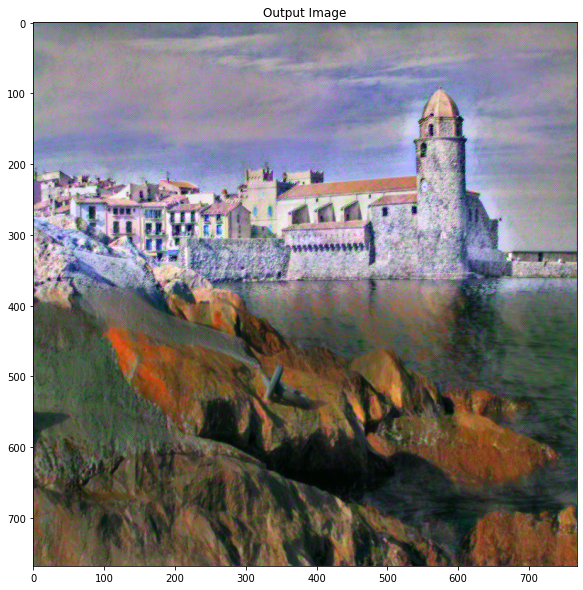

In [35]:
plt.figure(figsize=(10,10))
imshow(output2, title='Output Image')
plt.ioff()
plt.show()

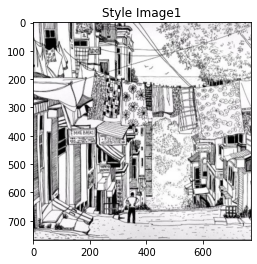

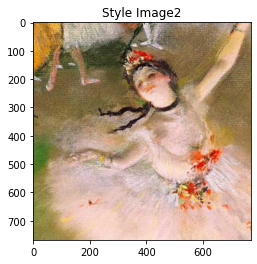

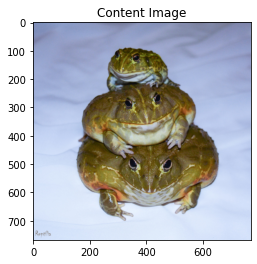

In [31]:
plt.figure()
imshow(graphics, title='Style Image1')
plt.figure()
imshow(degas, title='Style Image2')
plt.figure()
imshow(frogs, title='Content Image')

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


run [50]:
Style Loss : 19.357525 Content Loss: 23.803057



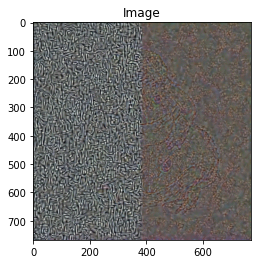

run [100]:
Style Loss : 7.131506 Content Loss: 18.583256



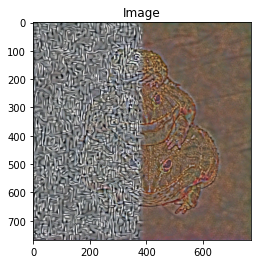

run [150]:
Style Loss : 3.971010 Content Loss: 16.062662



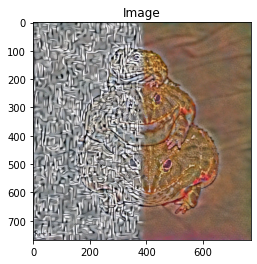

run [200]:
Style Loss : 2.918066 Content Loss: 14.719791



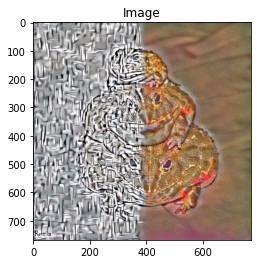

run [250]:
Style Loss : 2.306193 Content Loss: 14.022360



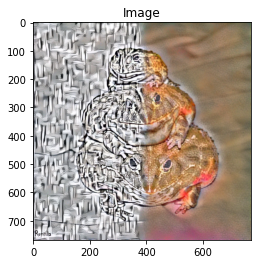

run [300]:
Style Loss : 2.315263 Content Loss: 14.186181



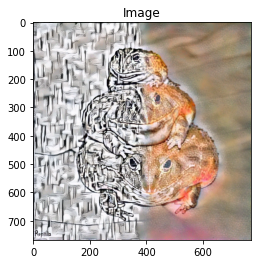

run [350]:
Style Loss : 5.683090 Content Loss: 14.088818



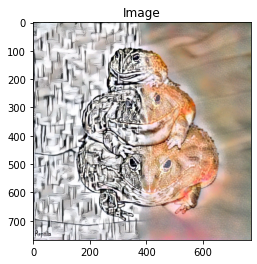

run [400]:
Style Loss : 1.961392 Content Loss: 13.562417



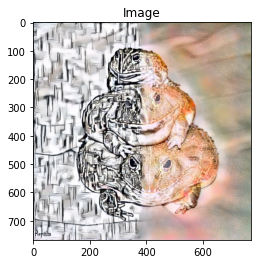

run [450]:
Style Loss : 3.701598 Content Loss: 13.475815



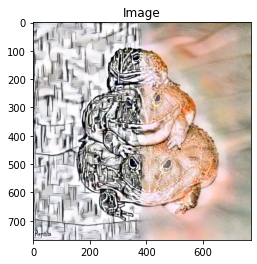

run [500]:
Style Loss : 2.934069 Content Loss: 14.059067



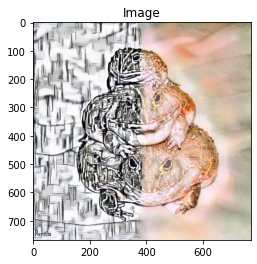

In [32]:
torch.manual_seed(42)
input_img = torch.randn(frogs.data.size(), device=device)
output3 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            frogs, graphics, degas, input_img, mode = 'lr')

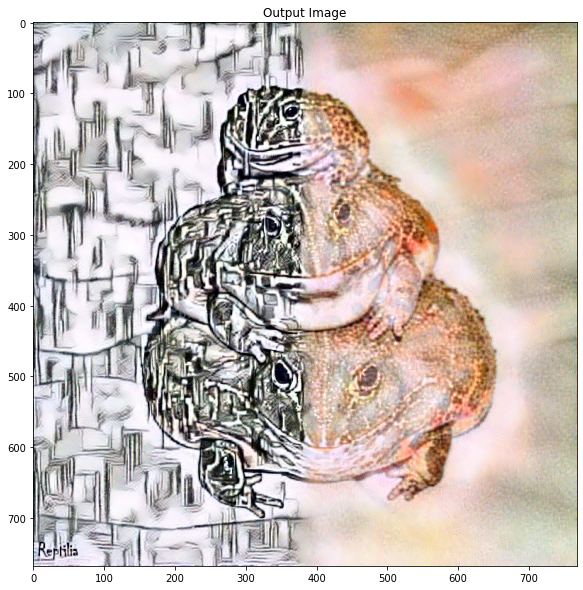

In [34]:
plt.figure(figsize=(10,10))
imshow(output3, title='Output Image')
plt.ioff()
plt.show()

## Итого 
При помощи модификации функций потерь и функции вычисления матрицы Грама получилось достичь желаемых результатов: переноса двую стилей одновременно, а также двух стилей на разные части картинки.